In [1]:
import math

import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models, layers, datasets

Using TensorFlow backend.


# A SF Permits Cleaning

### Methode um Y/NaN Spalten zu konvertieren

In [2]:
def replace_y_with_0_1(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Ersetzt Y und leere Felder in Spalten die nur Y und leere Felder erhalten durch 1 und 0 
    :param df: Dataframe in dem sich die Spalten befinden
    :param column: Name der Spalte in der die Werte ersetzt werden sollen
    :return: DataFrame mit modifizierten Spalten
    """
    df[column].fillna(0, inplace=True)
    df[column].replace('Y', 1, inplace=True)
    return df

### Datenset laden

In [3]:
permits_df = pd.read_csv("building_permits.csv")

c:\users\d074009\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# B SF Permits Exploration

# C SF Permits Prediction

### Methode für One-Hot-Encoding

In [4]:
def one_hot_encode(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Erzeugt Dummy-Spalten für jeden Wert in der Quell-Spalte.
    
    Beispiel:
    Wenn eine Tabelle die Spalte 'Klasse' mit 0, 1, 2 als Werte hat, werden die Spalte Klasse 0, Klasse 1 und Klasse 2
    erstellt und die Zeilen der Tabelle an den entsprechenden Stellen auf 0 bzw. 1 gesetzt. 
    :param df: Dataframe in dem die zu ersetzende Spalte ist
    :param col: Spalte die One-Hot-Encoded werden soll
    :return: modifizierter DataFrame
    """
    return df.assign(**{str(col + " " + str(val)): [1 if str(val) in str(cell) else 0 for cell in df[col]] 
                                   for val in df[col].unique()})

# D SF Challenges

# E Neural Networks XOR

![XOR Graph](XOR.png)

w: weight  
b: bias  
t: threshold

Mathematische Funktion:
```
SIGMOID(x) = 1 / (1 + e^(-x))
AND(x, y) = SIGMOID(50x + 50y - 75)
OR(x, y) = SIGMOID(50x + 50y - 25)
NOT(x) = SIGMOID(-50x + 10)

XOR(x, y) = AND(NOT(AND(x, y)), OR(x, y))

XOR(x,y) = SIGMOID(SIGMOID(SIGMOID(50x + 50y - 75) * (-50) + 10) * 50 + SIGMOID(50x + 50y - 25) * 50 - 75)
           \       \       \---------AND---------/             /        \                     /          /
            \       \-------------------NOT-------------------/          \--------OR---------/          /
             \-------------------------------------------AND-------------------------------------------/
```

### Funktionen in Python abbilden und testen

In [5]:
def SIGMOID(x):
    return 1 / (1 + (math.e ** (-x)))

def AND(x, y):
    return SIGMOID(x * 50 + y * 50 - 75)

def OR(x, y):
    return SIGMOID(x * 50 + y * 50 - 25)
    
def NOT(x):
    return SIGMOID(x * (-50) + 10)

def XOR(x, y):
    return AND(NOT(AND(x, y)),OR(x, y))

print(round(XOR(0, 0), 10))
print(round(XOR(0, 1), 10))
print(round(XOR(1, 0), 10))
print(round(XOR(1, 1), 10))

0.0
1.0
1.0
0.0


# F Neural Networks Overfitting

### Daten Laden und splitten

In [6]:
(X_train, Y_train), (X_test, Y_test) = datasets.cifar10.load_data()

X_train, X_test = X_train / 255.0, X_test / 255.0

num_classes = 10

### Modell erstellen

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

### Modell in 40 Epochen trainieren und jede Epoche die Genauigkeit messen

In [8]:
acc_train, acc_test = [], []
for i in range(40):
    model.fit(X_train, Y_train, batch_size=100, epochs=1)
    acc_train.append(model.evaluate(X_train, Y_train)[1])
    acc_test.append(model.evaluate(X_test, Y_test)[1])

Epoch 1/1
10000/10000 [==============================] - 3s 286us/step
Epoch 1/1
10000/10000 [==============================] - 3s 282us/step
Epoch 1/1
10000/10000 [==============================] - 5s 451us/step
Epoch 1/1
10000/10000 [==============================] - 4s 373us/step
Epoch 1/1
10000/10000 [==============================] - 4s 432us/step
Epoch 1/1
10000/10000 [==============================] - 3s 332us/step
Epoch 1/1
10000/10000 [==============================] - 3s 312us/step
Epoch 1/1
10000/10000 [==============================] - 3s 343us/step
Epoch 1/1
10000/10000 [==============================] - 3s 320us/step
Epoch 1/1
10000/10000 [==============================] - 3s 345us/step
Epoch 1/1
10000/10000 [==============================] - 4s 355us/step
Epoch 1/1
10000/10000 [==============================] - 3s 326us/step
Epoch 1/1
10000/10000 [==============================] - 3s 328us/step
Epoch 1/1
10000/10000 [==============================] - 3s 339us/step
Epoch 

10000/10000 [==============================] - 3s 320us/step
Epoch 1/1
10000/10000 [==============================] - 3s 332us/step
Epoch 1/1
10000/10000 [==============================] - 4s 353us/step
Epoch 1/1
10000/10000 [==============================] - 4s 437us/step
Epoch 1/1
10000/10000 [==============================] - 4s 381us/step


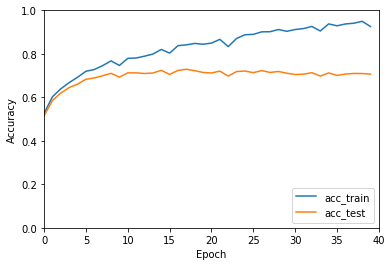

In [9]:
plt.plot(acc_train, label='acc_train')
plt.plot(acc_test, label='acc_test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.xlim([0,40])
plt.legend(loc='lower right')

Die Genauigkeit der Vorhersage von Labels des Trainings-Sets erhöht sich kontinuierlich aber die Genauigkeit bei den
Test-Daten steigt auf ca 72% an und fällt dann aber wieder auf 69% ab. Das Modell lernt die Bilder aus dem
Trainings-Set auswendig und kann deswegen keine guten Vorhersagen für das Test-Set machen.

# G Neural Networks Overfitting

# H Feedback